In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
Layer=keras.layers.Layer

class Time2Vector(Layer): #Time embedding layer
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)
class SingleAttention(Layer): #Attention layer
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = tf.keras.layers.Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = tf.keras.layers.Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = tf.keras.layers.Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out 

class MultiAttention(Layer): #Multihead attention
  def __init__(self, d_k, d_v, n_heads,filt_dim):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.filt_dim=filt_dim
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    self.linear = tf.keras.layers.Dense(self.filt_dim, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

class TransformerEncoder(Layer): #Combining everything into a Transformer encoder
  def __init__(self, d_k, d_v, n_heads, ff_dim,filt_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.filt_dim=filt_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads,self.filt_dim)
    self.attn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.attn_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = tf.keras.layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = tf.keras.layers.Conv1D(filters=self.filt_dim, kernel_size=1) # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.ff_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.ff_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

In [2]:
import deeptrack as dt
IMAGE_SIZE=64
sequence_length=10#Number of frames per sequence
MIN_SIZE=.5e-6
MAX_SIZE=1.5e-6
MAX_VEL=10 #Maximum velocity. The higher the trickier!
MAX_PARTICLES=3 #Max number of particles in each sequence. The higher the trickier!

#Defining properties of the particles
particle=dt.Sphere(intensity=lambda: 10+10*np.random.rand(),
                   radius=lambda: MIN_SIZE+np.random.rand()*(MAX_SIZE-MIN_SIZE),
                   position=lambda: IMAGE_SIZE*np.random.rand(2),vel=lambda: MAX_VEL*np.random.rand(2),
                   position_unit="pixel")

#Defining an update rule for the particle position
def get_position(previous_value,vel):

    newv=previous_value+vel
    for i in range(2):
        if newv[i]>63:
            newv[i]=63-np.abs(newv[i]-63)
            vel[i]=-vel[i]
        elif newv[i]<0:
            newv[i]=np.abs(newv[i])
            vel[i]=-vel[i]
    return newv

particle=dt.Sequential(particle,position=get_position)

#Defining properties of the microscope
optics=dt.Fluorescence(NA=1,output_region= (0, 0,IMAGE_SIZE, IMAGE_SIZE), 
    magnification=10,
    resolution=(1e-6, 1e-6),
    wavelength=633e-9)

#Combining everything into a dataset. 
#Note that the sequences are flipped in different directions, so that each unique sequence defines
#in fact 8 sequences flipped in different directions, to speed up data generation
dataset=dt.FlipUD(dt.FlipDiagonal(dt.FlipLR(dt.Sequence(optics(particle**(lambda: 1+np.random.randint(MAX_PARTICLES))),sequence_length=sequence_length))))


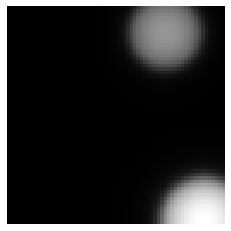

In [3]:
dataset.update().plot(cmap="gray") #This generates a new sequence and plots it
video=dataset.update().resolve() #This generates a new sequence and stores in in "video"

In [10]:
class Encoder(Layer):
  def __init__(self, features):
    super(Encoder, self).__init__()
    self.hidden_layer = tf.keras.layers.Dense(
      units=features,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=features,
      activation=tf.nn.sigmoid
    )
    
  def call(self, input_features):
    activation = self.hidden_layer(input_features)
    return self.output_layer(activation)

class Decoder(Layer):
  def __init__(self, intermediate_features, original_features):
    super(Decoder, self).__init__()
    self.hidden_layer = tf.keras.layers.Dense(
      units=intermediate_features,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=original_features,
      activation=tf.nn.sigmoid
    )
  
  def call(self, code):
    activation = self.hidden_layer(code)
    return self.output_layer(activation)

class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_features, original_features):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_features)
    self.decoder = Decoder(intermediate_features, original_features)
  
  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

In [9]:
def loss(model, original):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
  return reconstruction_error

def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model, original), model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)

learning_rate = 0.01
epochs = 4
batch_size = 64
autoencoder = Autoencoder(64, 64*64)
opt = tf.optimizers.Adam(learning_rate=learning_rate)

(training_features, _), (test_features, _) = tf.keras.datasets.mnist.load_data()
training_features = training_features / np.max(training_features)
training_features = training_features.reshape(training_features.shape[0],
                                              training_features.shape[1] * training_features.shape[2])
training_features = training_features.astype('float32')
training_dataset = tf.data.Dataset.from_tensor_slices(training_features)
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(training_features.shape[0])
training_dataset = training_dataset.prefetch(batch_size * 4)

writer = tf.summary.create_file_writer('tmp')

with writer.as_default():
  with tf.summary.record_if(True):
    for epoch in range(epochs):
      for step, batch_features in enumerate(training_dataset):
        train(loss, autoencoder, opt, batch_features)
        loss_values = loss(autoencoder, batch_features)
        original = tf.reshape(batch_features, (batch_features.shape[0], 28, 28, 1))
        reconstructed = tf.reshape(autoencoder(tf.constant(batch_features)), (batch_features.shape[0], 28, 28, 1))
        tf.summary.scalar('loss', loss_values, step=step)
        tf.summary.image('original', original, max_outputs=10, step=step)
        tf.summary.image('reconstructed', reconstructed, max_outputs=10, step=step)